##Multi Object Detection using API

### Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.11.0
The following GPU devices are available: /device:GPU:0


### Utilities Function

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  #absolute pathname of a fie
  _, filename = tempfile.mkstemp(suffix=".jpg")
  #open the url and read it
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  #Image processing
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  #Save the image
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

### Image Detection

In [ ]:
url       = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector  = hub.load(url).signatures['default']s

In [ ]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Moore_Street_market%2C_Dublin.jpg/1280px-Moore_Street_market%2C_Dublin.jpg"
width  = 2122
height = 1414
downloaded_image_path = download_and_resize_image(img_url, width, height)

Image downloaded to /tmp/tmprdh16ujj.jpg.


In [ ]:
print("Image Path : ",downloaded_image_path)

Image Path :  /tmp/tmprdh16ujj.jpg


In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img 

In [ ]:
img_dublin = load_img(downloaded_image_path)
img_dublin_predict = tf.image.convert_image_dtype(img_dublin, tf.float32)[tf.newaxis, ...]
result     = detector(img_dublin_predict)

In [ ]:
r = {key : value.numpy() for key , value in result.items()}

In [ ]:
print("Type of result : ",type(result))
print("keys : ",result.keys())

Type of result :  <class 'dict'>
keys :  dict_keys(['detection_class_names', 'detection_class_entities', 'detection_class_labels', 'detection_scores', 'detection_boxes'])


In [ ]:
len(result['detection_class_names'])

100

In [ ]:
img_dublin_box = draw_boxes(
      img_dublin.numpy(), r["detection_boxes"],
      r["detection_class_entities"], r["detection_scores"])

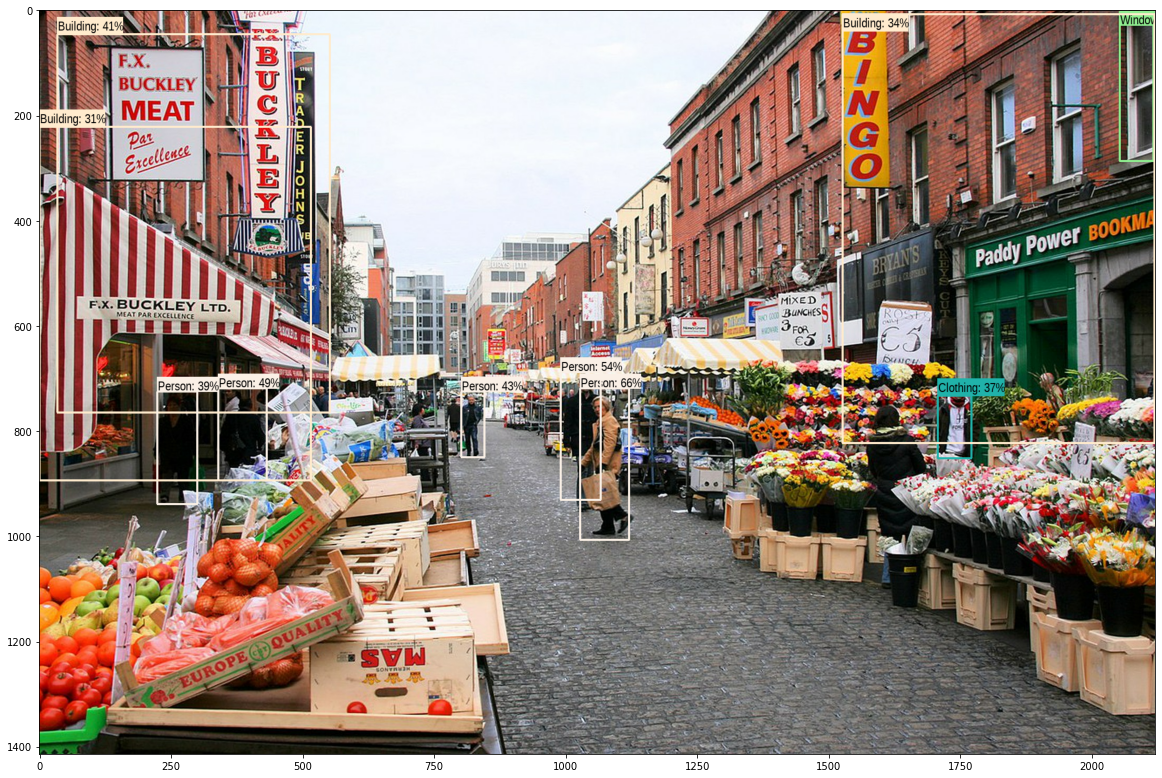

In [ ]:
display_image(img_dublin_box)

In [ ]:
def predict_on_image(img_url , width = 256 , height = 256 , show_img = True , max_boxes = 10):
    downloaded_image_path = download_and_resize_image(img_url, width, height)
    # load img and predict object label , position , accur
    img                = load_img(downloaded_image_path)
    converted_img      = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result             = detector(converted_img)
    result             = {key : value.numpy() for key , value in result.items()}
    box_img            = draw_boxes(img.numpy(), result["detection_boxes"],result["detection_class_entities"], result["detection_scores"] , max_boxes=max_boxes)
    if show_img:
        display_image(box_img)
    return box_img

Image downloaded to /tmp/tmpre23rfes.jpg.


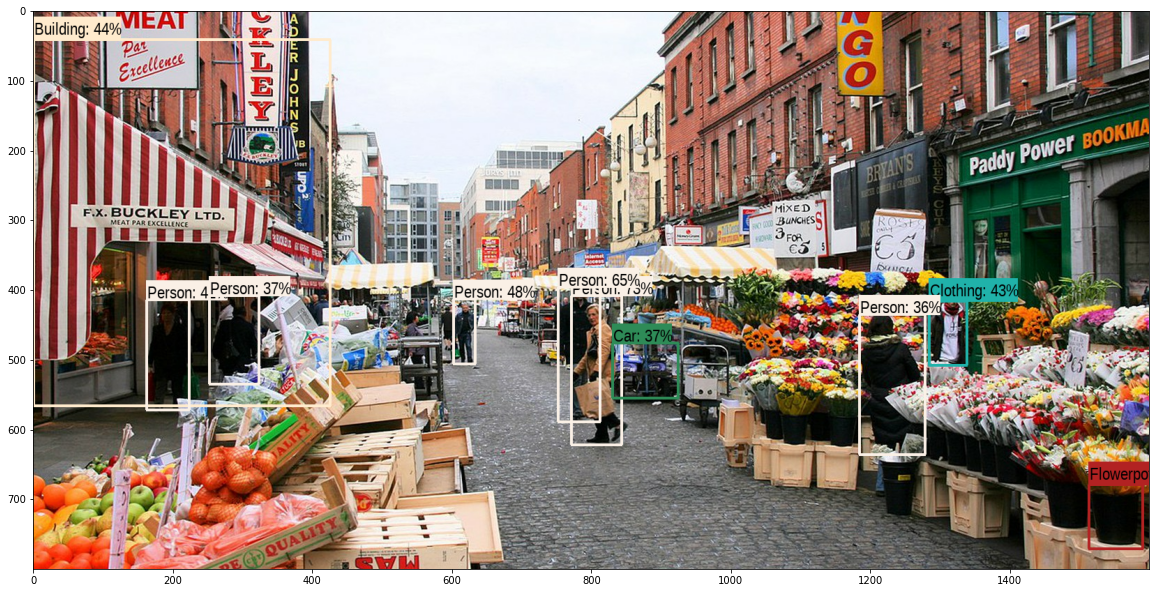

In [ ]:
box_img = predict_on_image("https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Moore_Street_market%2C_Dublin.jpg/1280px-Moore_Street_market%2C_Dublin.jpg" ,
                 1600 ,
                 800)

Image downloaded to /tmp/tmpth19zuhd.jpg.


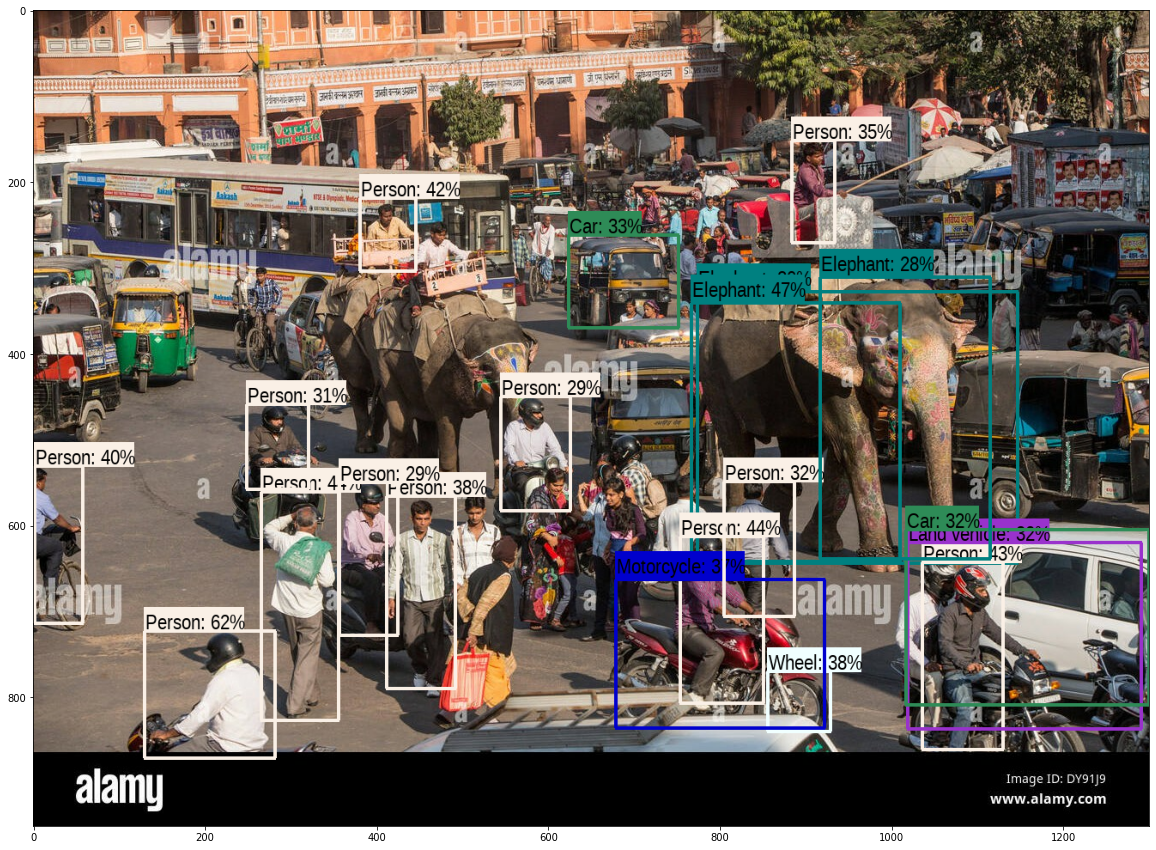

In [ ]:
url = "https://c8.alamy.com/comp/DY91J9/traffic-jaipur-rajasthan-india-asia-india-traffic-transport-elephant-DY91J9.jpg"
box_img = predict_on_image(url , 1300 , 950, max_boxes=20)

Image downloaded to /tmp/tmp_qe20l00.jpg.


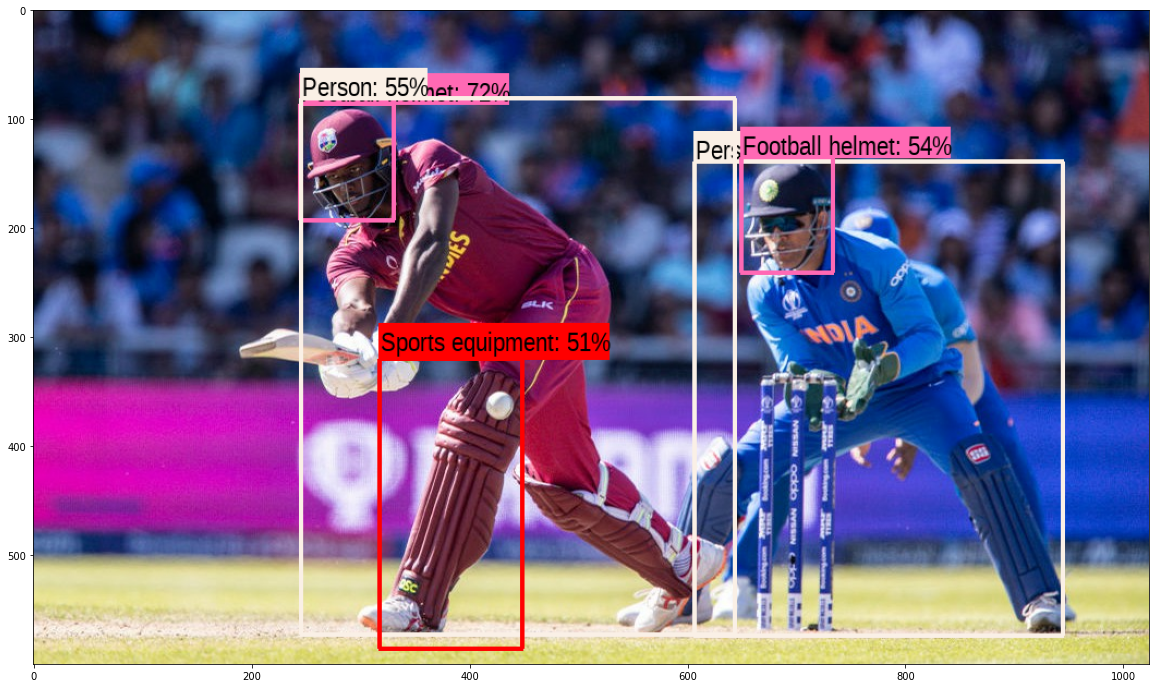

In [ ]:
url = "https://cdn-wp.thesportsrush.com/2019/07/GettyImages-1152291254.jpg"
box_img = predict_on_image(url , 1024 , 600 , max_boxes = 5)

Image downloaded to /tmp/tmp0t8r3dmf.jpg.


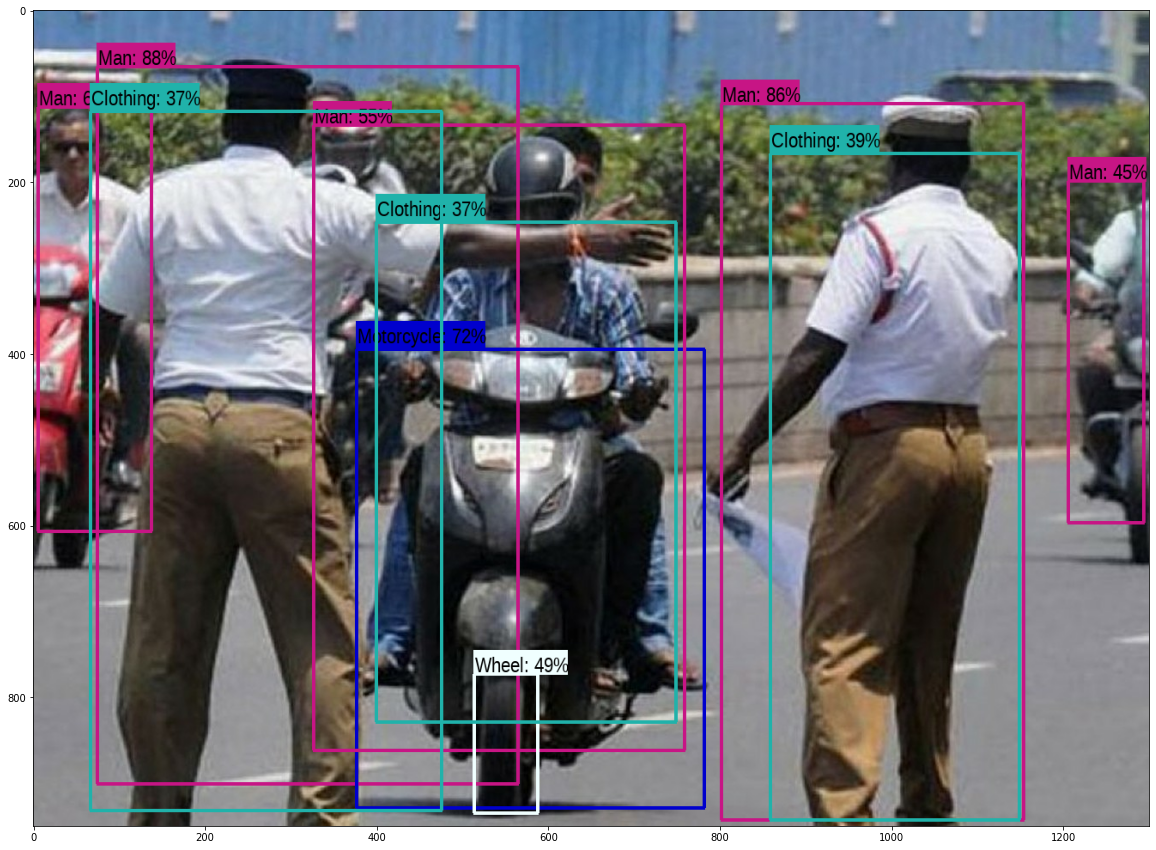

In [ ]:
url = "https://www.theweek.in/content/dam/week/news/india/images/2019/9/3/traffic-police-manorama.jpg.transform/schema-16x9/image.jpg"
box_img = predict_on_image(url , 1300 , 950)